# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [ ]:
# !pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [1]:
import time

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 6d155712


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

# NOTE - I WILL UPLOAD A PDF FILE LOCALLY BELOW!!! 

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# file_path = list(uploaded.keys())[0]
# file_path

We'll define our chunking strategy.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader
Loader = PyMuPDFLoader

In [7]:
pdf_filepath = './data/2023ltr.pdf'

In [8]:

loader = Loader(pdf_filepath)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [10]:

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"

client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)

vectorstore.add_documents(docs)

retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

# IMPORTANT NOTE - PLEASE READ !!!!!

1.  I am not a software engineer and found the coverage of the concepts on CACHING in the lectures etc. to be very fast paced.

2.  When I asked folks in various channels (peer supporters, etc.) for resources to learn about the material, many suggested setting up a ChatGPT Assistant specializing in software engineering practices to help me further understand the concepts.

3.  I used ChatGPT extensively to answer the questions in this notebook.

4.  Further, I preferred in many cases to save the exact responses from ChatGPT in the notebook so that I can archive these detailed and helpful replies as my notes for the future.

5.  Thus, you will find that in many cases the responses are a bit verbose and rather detailed.  Rest assured, I have carefully read and understood the responses.  But this is just a heads-up that these responses are mostly from ChatGPT interface.


# ANSWER#1


# Some Limitations of this Approach


1.  The Qdrant instance is an `in-memory` implementation of a vectorstore.

-  `Storage is not persisent`: This means that the data does not persist between sessions.  If the system shuts down, all the indexed data will be lost.  And this could be an issue in prod where persistence is crucial.

-  `Does not scale well`: Since this is an in-memory solution, it won’t scale well for large datasets due to RAM memory capacity limitations. If/when the corpus grows, i.e., number of documents increase significantly, and/or the desired embeddings size increases (e.g., switching from `te3-small` to `te3-large` will double the size of the embeddings), memory capacity will become a huge constraint.


2.  Local Cache with `LocalFileStore`

-  `Single Node Storage`: The cache is stored locally on the disk using `LocalFileStore`. While this is fine for simple or single-machine setups, it doesn’t work well in distributed environments where multiple servers or instances need to share the same cache. This would cause cache fragmentation and inconsistency across nodes.

-  `Performance Overhead for Disk I/O`: Accessing cached embeddings from the disk (especially with large files) can introduce latency. While it improves upon recomputing embeddings every time, disk access (especially on slower storage systems) may still not be fast enough for real-time requirements compared to using an in-memory cache like Redis or Memcached.

-  `No Cache Expiration Mechanism`: There is no clear _cache eviction_ or _expiration_ policy. If embeddings change (due to model upgrades or document changes), the cache could become stale. It may continue to serve outdated embeddings unless explicitly handled.


3.   Limited Error Handling and Redundancy

-  There doesn’t seem to be any handling of what happens if the cache store fails or the Qdrant client goes down. In a more robust system, fallbacks or error handling strategies would be necessary to avoid downtime or data loss.


4.  Cache Invalidation & Versioning.

-  `Cache Staleness`: The cache might store outdated or irrelevant embeddings if documents change. There's no versioning or invalidation mechanism in place to handle updated documents or embeddings.

-  `Namespace Conflicts`: Using the embedding model name as the namespace (namespace=core_embeddings.model) could lead to conflicts if multiple embedding models of the same name but different parameters or versions are used. A more robust approach would involve versioning the namespace with additional context about the embeddings.


5.  Embedding Size Limit

-  The `CacheBackedEmbeddings` is useful for reusing embeddings, but if embeddings grow too large (either in vector size or number of documents), the cache itself may become inefficient. For example, the size of embeddings could increase storage requirements significantly.


# When is this Approach Most Useful?  And, Least Useful?

## Most Useful


1.  `Small-scale or Development Environments`: This setup is great for local development and small-scale projects where the dataset is relatively small, and the focus is on rapid prototyping or testing. The :memory: Qdrant instance allows us to experiment without setting up external infrastructure, and the local file store can quickly handle simple caching without needing to integrate more complex distributed caches.


2.  `Frequent Reuse of Embeddings`: If the same documents or queries are frequently processed, and embeddings are often recomputed, this caching layer will speed up operations by reusing previously computed embeddings.


3.  `Latency Reduction for Computationally Expensive Embeddings`: For larger models or embeddings that take significant time to generate (like those from OpenAI models), caching can reduce costs and improve response times.


## Least Useful


1.  `Production-Grade, Scalable Applications`: For production environments, especially where multiple nodes or instances need to share data, this approach falls short. Local caching and an in-memory database won’t scale well, and the risk of losing data on system restarts makes it unsuitable for mission-critical applications.


2.  `Large Datasets`: When handling large numbers of documents or embeddings, disk-based local caches and in-memory Qdrant stores will likely encounter performance bottlenecks. You would need a more distributed and scalable solution (e.g., using persistent Qdrant instances and a distributed cache like Redis).


3.  `Highly Dynamic Data`: If documents are frequently updated, and embeddings need to be refreshed, the cache will need to be invalidated regularly. Without a mechanism to handle this, we would risk retrieving outdated data, making the caching mechanism less useful or even harmful.


4.  `Distributed Systems`: In scenarios with distributed servers or containerized applications (like microservices), the local cache will be ineffective, as each instance will have its own cache, leading to duplication and inconsistencies.


# Potential Improvements


1.  `Persistent Qdrant`: Use a persistent Qdrant instance (e.g., with file-based or remote storage) to ensure data is not lost across sessions.


2.  `Distributed Cache`: Instead of `LocalFileStore`, integrate a distributed caching mechanism like Redis, which can handle multiple nodes and provide faster access than disk-based caching.


3.  `Cache Invalidation`: Implement a _cache invalidation_ or _expiration_ strategy, especially in environments where data is frequently updated.


4.  `Scalable Vector Storage`: If scaling becomes necessary, we can look into cloud-managed services or on-disk databases that can scale horizontally.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

## ACTIVITY #1:

I will upload the same document twice and show that there is a drastic reduction in the time taken to embed the document the second time.

In [ ]:
### YOUR CODE HERE

# In this cell, we will start from scratch and load a pdf file and create embeddings.

In [ ]:
## UPLOAD A NEW FILE TO DO ACTIVITY #1
# uploaded = files.upload()

In [ ]:
# VERIFY FILE IS UPLOADED AND HAS THE CORRECT PATH
# file_path = list(uploaded.keys())[0]
# file_path

In [11]:
new_pdf_file_path = 'https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf'


In [12]:
loader = Loader(new_pdf_file_path)

In [13]:
documents = loader.load()

docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"


In [14]:
start_time = time.time()

vectorstore.add_documents(docs)

end_time = time.time()

print(f'time taken in seconds: FIRST TIME: {end_time - start_time}')

time taken in seconds: FIRST TIME: 4.448815107345581


In [15]:
start_time = time.time()

vectorstore.add_documents(docs)

end_time = time.time()

print(f'time taken in seconds: SECOND TIME: {end_time - start_time}')

time taken in seconds: SECOND TIME: 0.1288759708404541


# ACTIVITY #1 - SEE ABOVE CELLS

First time takes 4.45 seconds

Second time takes 0.13 seconds

Shows the benefits of caching to speed up embedding generation.


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [16]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [17]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [18]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

# ANSWER #2:

## Limitations of Prompt Caching

1.  Cache Invalidation
One of the trickiest parts of caching in general is knowing when to invalidate or refresh the cache. If cached responses are based on outdated information, the system may return inaccurate or irrelevant results. Ensuring that the cache is synchronized with the latest data requires intelligent invalidation strategies, which can be complex to implement effectively.


2.  Handling Dynamic Prompts
Some prompts include dynamic elements like user context, time-sensitive information, or personalized queries. These dynamic elements often mean that two seemingly similar prompts may need different responses, making caching less useful or even harmful if the wrong data is served from the cache.


3.  High Memory Usage
Storing cached results, especially for a large number of prompts, can consume significant amounts of memory. This becomes even more problematic if the RAG system is handling multiple users or complex, large responses, such as embeddings or retrieved documents, in the cache. Memory constraints might lead to the system needing to prune the cache aggressively, reducing the overall effectiveness of caching.


4.  Difficulty in Caching Long-Tail Queries
Many RAG systems deal with long-tail queries, where users input diverse and rarely repeated prompts. In such cases, caching offers limited benefit since the chances of a prompt repeating are low. Essentially, the cache will mostly store items that will never be reused, wasting resources.


5.  Cache Fragmentation
In systems where prompts are slightly varied but semantically similar, caching can result in fragmentation. Similar prompts might produce slightly different cache entries, even though they could share a similar or identical result if handled more intelligently. This leads to inefficiency, as multiple cache slots are used for what is effectively the same content.


6.  Privacy and Security Concerns
Caching prompts and their corresponding responses can pose risks in systems handling sensitive or private user information. If sensitive data is cached and not carefully managed, it could be accidentally served to another user or retained longer than necessary.


7.  Difficulty in Caching Multi-Step Queries
RAG systems often involve multi-step interactions or follow-up queries, where the user asks one question and then refines their request based on the response. Caching a single prompt doesn't easily capture the evolving nature of such interactions, leading to potential inconsistencies if a cached result is served at an inappropriate time.


## Most Useful Scenarios

1.  Frequent repetition of similar prompts - e.g., customer chatbots answering the same questions from different cusatomers.

2.  Underlying data is static or changes slowly



## Least Useful Scenarios

1.  Data is changing quite quickly - e.g., stock market performance, etc.

2.  When time, place or other entity is an integral part of the query.

3.  Complex queries.

4.  Sensitive data.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

## SEE BELOW FOR ACTIVITY 2!!!

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [19]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [20]:
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "What are some of the harmful effects of AI?"})
end_time = time.time()
print(f'time taken in seconds: FIRST TIME: {end_time - start_time}')

time taken in seconds: FIRST TIME: 3.6146411895751953


In [21]:
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "What are some of the harmful effects of AI?"})
end_time = time.time()
print(f'time taken in seconds: SECOND TIME: {end_time - start_time}')

time taken in seconds: SECOND TIME: 0.3405036926269531


# ACTIVITY #2 - SEE ABOVE CELLS

Prompt Caching Works...

First-time query takes: 3.61 seconds

Repeat query takes: 0.34 seconds

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

# ACTIVITY #3:

I will upload a new pdf to the vector store and run the RAG pipeline twice with the same prompt.  By construction, the first go-around is not using cache-backed embeddings as the cache is being created for the first time.  The second go-around is most definitely using cache-backed embeddings as the identical document is loaded and the RAG pipeline handles the exact same query.

In [22]:
new_pdf_file_path = 'https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf'
loader = Loader(new_pdf_file_path)

In [28]:
documents = loader.load()

docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

vectorstore.add_documents(docs)

In [24]:
start_time = time.time()
vectorstore.add_documents(docs)
end_time = time.time()
print(f'time taken in seconds: FIRST TIME: {end_time - start_time}')

time taken in seconds: FIRST TIME: 0.11732983589172363


In [25]:
start_time = time.time()
vectorstore.add_documents(docs)
end_time = time.time()
print(f'time taken in seconds: SECOND TIME: {end_time - start_time}')

time taken in seconds: SECOND TIME: 0.09835386276245117


In [26]:
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "What are some of the harmful effects of AI?"})
end_time = time.time()
print(f'time taken in seconds: FIRST TIME: {end_time - start_time}')

time taken in seconds: FIRST TIME: 4.9447410106658936


In [27]:
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "What are some of the harmful effects of AI?"})
end_time = time.time()
print(f'time taken in seconds: SECOND TIME: {end_time - start_time}')

time taken in seconds: SECOND TIME: 0.2904961109161377


# ACTIVITY #3 - SCREEN SHOTS BELOW

## FIRST RUN - LANGSMITH SCREEN SHOT

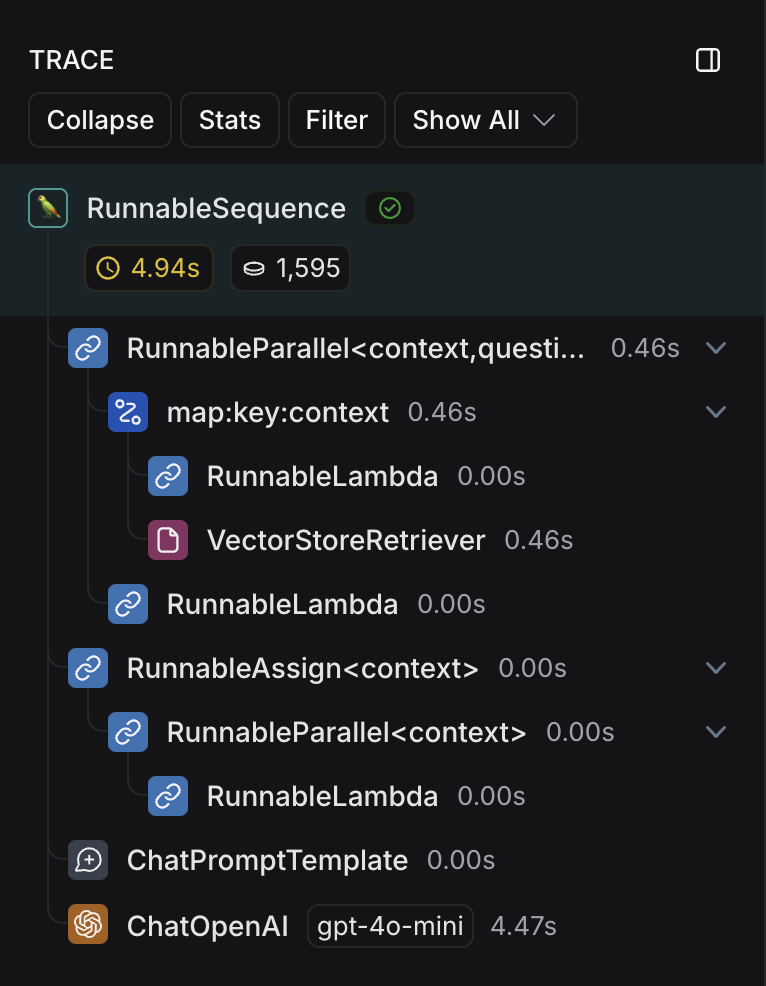

## SECOND RUN - LANGSMITH SCREEN SHOT

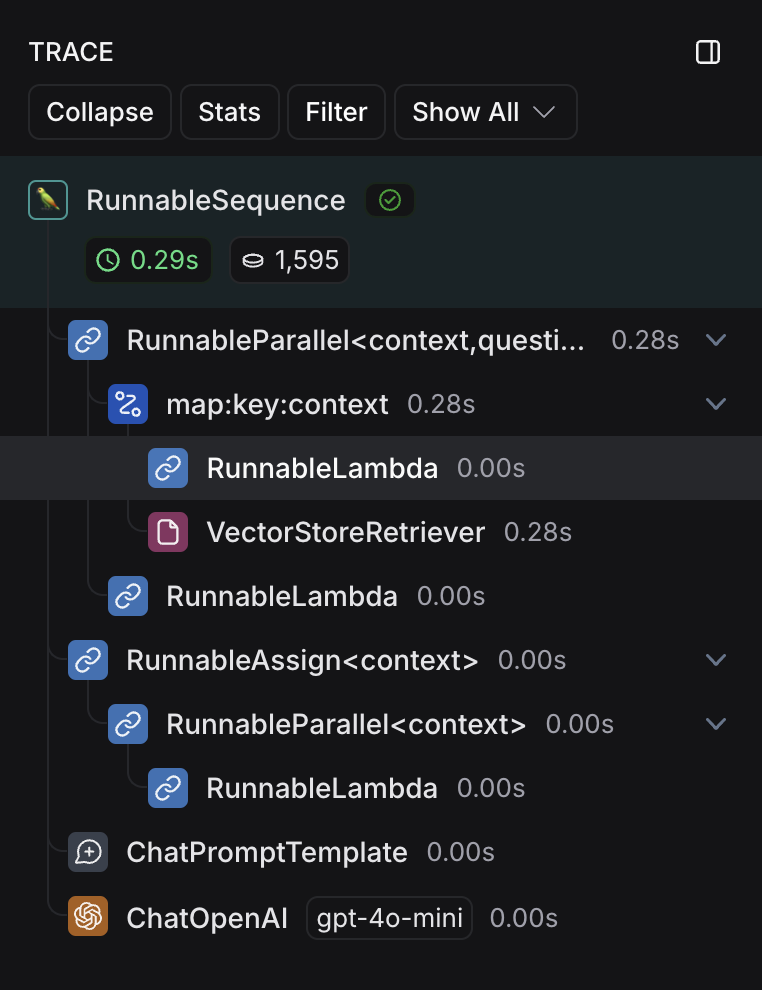


### REMARKS

Notice that the second run is significantly faster than the first one.

Latency is far less on the second run.

Vector store Retriever latency is lower.

And, OpenAI embeddings endpoint NOT USED in the second run.